<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/fasttext_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://keras.io/zh/examples/imdb_fasttext/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score

In [2]:
seed = 2021
ngram_range = 1 # if ngram_range=2 will add bi-grams features
input_dim = 5000
output_dim = 32
max_len = 500
batch_size = 128
epochs = 100
earlystopping_patience = 10

In [3]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=input_dim)

print(len(x_train), "train sequences")
print(len(x_test), "test sequences")
print("Average train sequence length: {}".format(np.mean(list(map(len, x_train)), dtype=int)))
print("Average valid sequence length: {}".format(np.mean(list(map(len, x_test)), dtype=int)))

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences
Average train sequence length: 238
Average valid sequence length: 230


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
# Preprocess the dataset


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences


if ngram_range > 1:
    print("Adding {}-gram features".format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than input_dim in order
    # to avoid collision with existing features.
    start_index = input_dim + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # input_dim is the highest integer that could be found in the dataset.
    input_dim = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print("Average train sequence length: {}".format(np.mean(list(map(len, x_train)), dtype=int)))
    print("Average test sequence length: {}".format(np.mean(list(map(len, x_test)), dtype=int)))
    
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)


In [5]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Epoch 1/100
176/176 [==============================] - 5s 12ms/step - loss: 0.6902 - accuracy: 0.5666 - val_loss: 0.6745 - val_accuracy: 0.7112
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6651 - accuracy: 0.7195 - val_loss: 0.6299 - val_accuracy: 0.7576
Epoch 3/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6158 - accuracy: 0.7634 - val_loss: 0.5749 - val_accuracy: 0.7840
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5594 - accuracy: 0.7967 - val_loss: 0.5231 - val_accuracy: 0.8080
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5065 - accuracy: 0.8282 - val_loss: 0.4784 - val_accuracy: 0.8316
Epoch 6/100
176/176 [==============================] - 2s 10ms/step - loss: 0.4624 - accuracy: 0.8467 - val_loss: 0.4404 - val_accuracy: 0.8508
Epoch 7/100
176/176 [==============================] - 2s 10ms/step - loss: 0.4202 - accuracy: 0.8616 - val_loss: 0.410

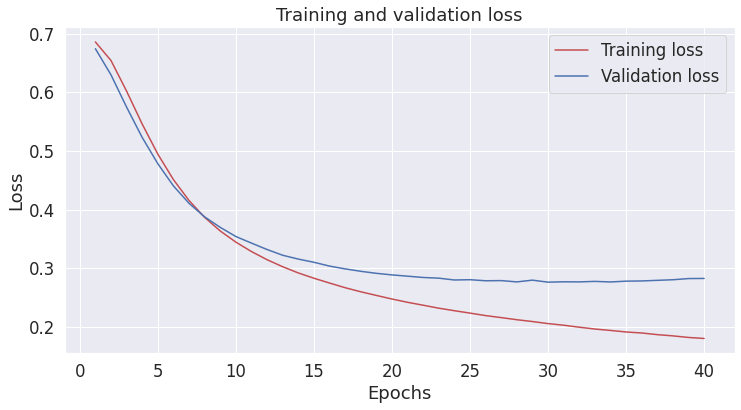

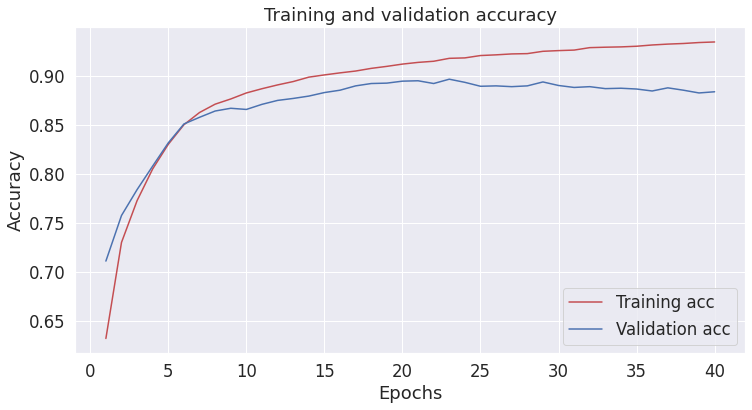

              precision    recall  f1-score   support

           0      0.886     0.886     0.886     12500
           1      0.886     0.886     0.886     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 2 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6895 - accuracy: 0.5569 - val_loss: 0.6738 - val_accuracy: 0.7140
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6622 - accuracy: 0.7272 - val_loss: 0.6286 - val_accuracy: 0.7556
Epoch 3/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6108 - accuracy: 0.7668 - val_loss: 0.5748 - val_accuracy: 0.7624
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5558 - accuracy: 0.7967 - val_loss: 0.5223 - val_accuracy: 0.8156
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5

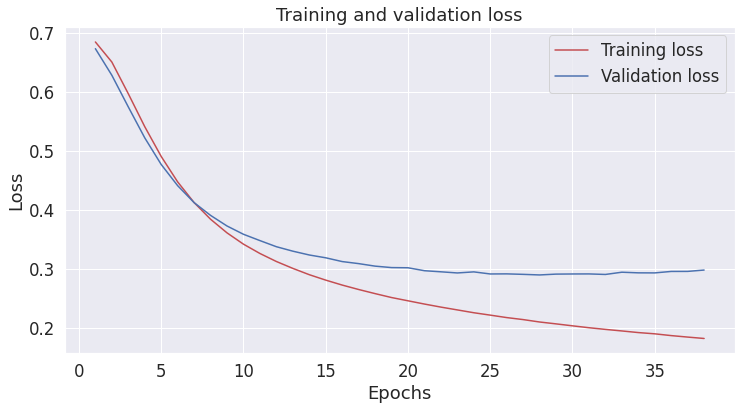

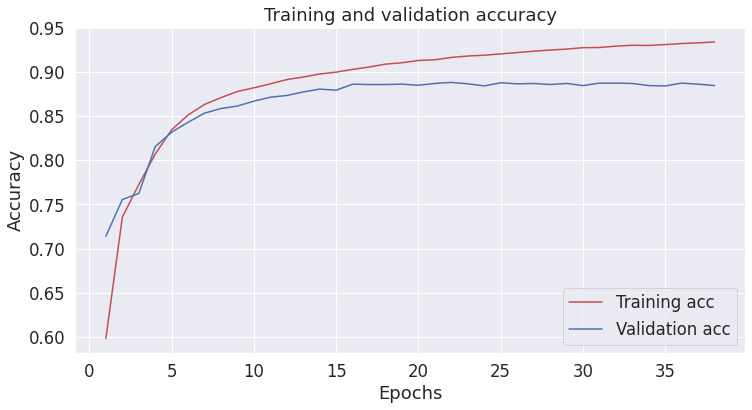

              precision    recall  f1-score   support

           0      0.892     0.883     0.887     12500
           1      0.884     0.893     0.888     12500

    accuracy                          0.888     25000
   macro avg      0.888     0.888     0.888     25000
weighted avg      0.888     0.888     0.888     25000


KFold: 3 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6898 - accuracy: 0.5833 - val_loss: 0.6732 - val_accuracy: 0.6952
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6636 - accuracy: 0.7116 - val_loss: 0.6273 - val_accuracy: 0.7540
Epoch 3/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6129 - accuracy: 0.7662 - val_loss: 0.5726 - val_accuracy: 0.7792
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5580 - accuracy: 0.7982 - val_loss: 0.5205 - val_accuracy: 0.8104
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5

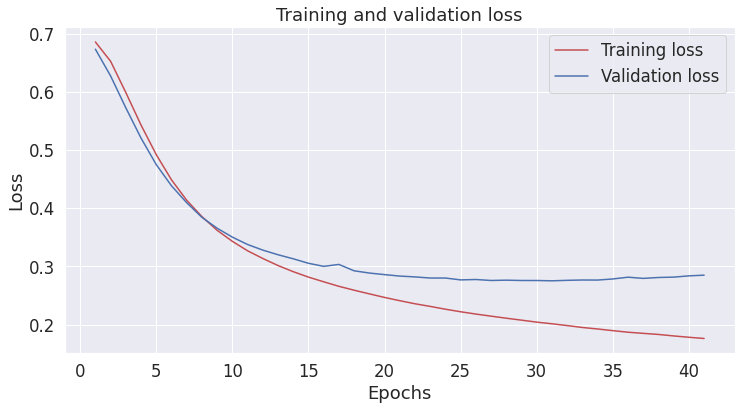

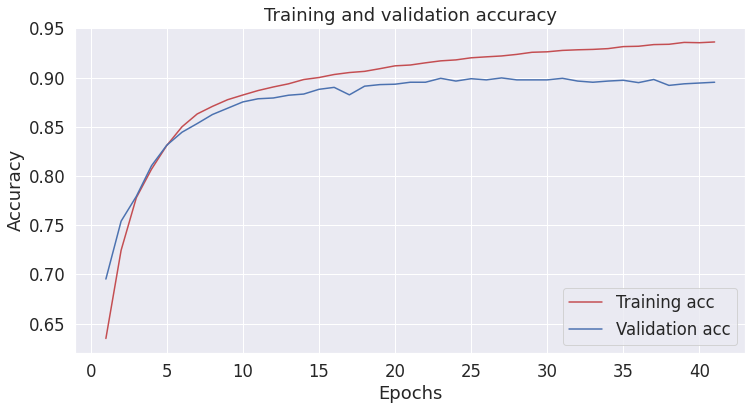

              precision    recall  f1-score   support

           0      0.898     0.874     0.886     12500
           1      0.877     0.900     0.889     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 4 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6897 - accuracy: 0.5689 - val_loss: 0.6730 - val_accuracy: 0.7200
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6622 - accuracy: 0.7222 - val_loss: 0.6276 - val_accuracy: 0.7376
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6107 - accuracy: 0.7704 - val_loss: 0.5723 - val_accuracy: 0.7768
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5545 - accuracy: 0.8065 - val_loss: 0.5189 - val_accuracy: 0.8152
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5

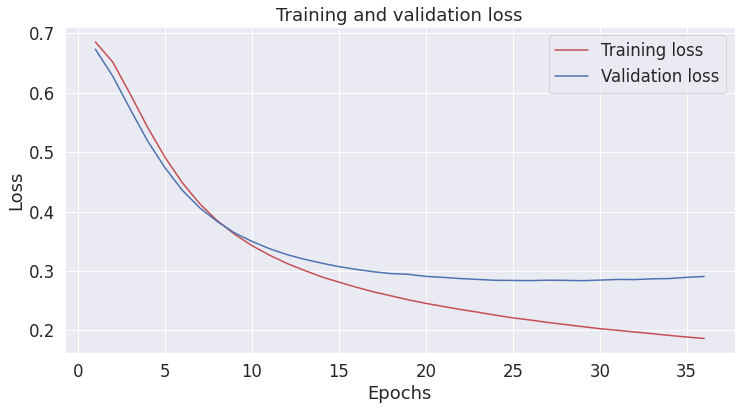

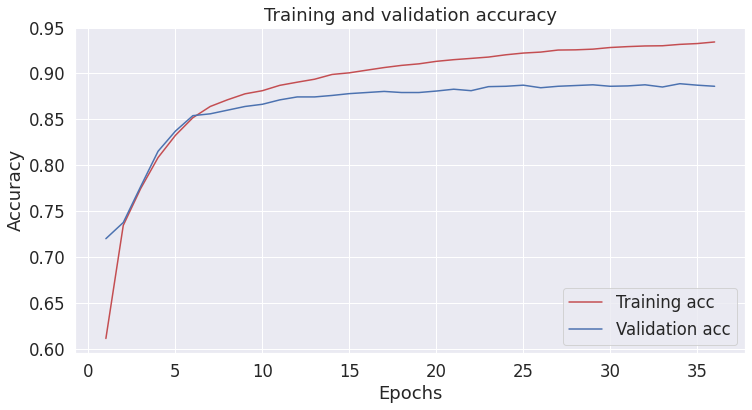

              precision    recall  f1-score   support

           0      0.884     0.889     0.887     12500
           1      0.889     0.884     0.886     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 5 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6900 - accuracy: 0.5720 - val_loss: 0.6749 - val_accuracy: 0.7204
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6635 - accuracy: 0.7335 - val_loss: 0.6309 - val_accuracy: 0.7460
Epoch 3/100
176/176 [==============================] - 2s 10ms/step - loss: 0.6121 - accuracy: 0.7652 - val_loss: 0.5767 - val_accuracy: 0.7784
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5549 - accuracy: 0.8022 - val_loss: 0.5248 - val_accuracy: 0.8052
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5

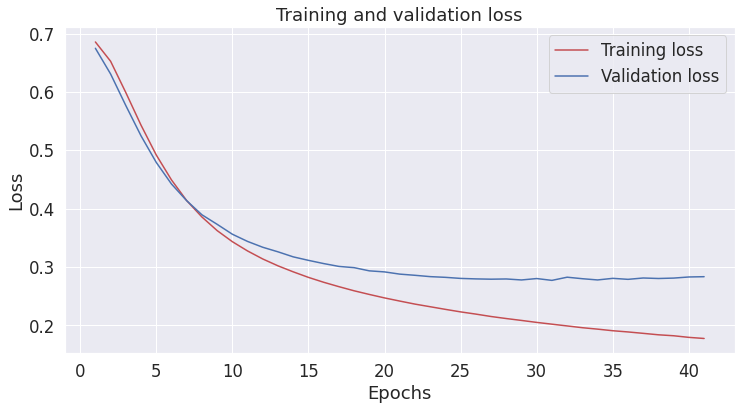

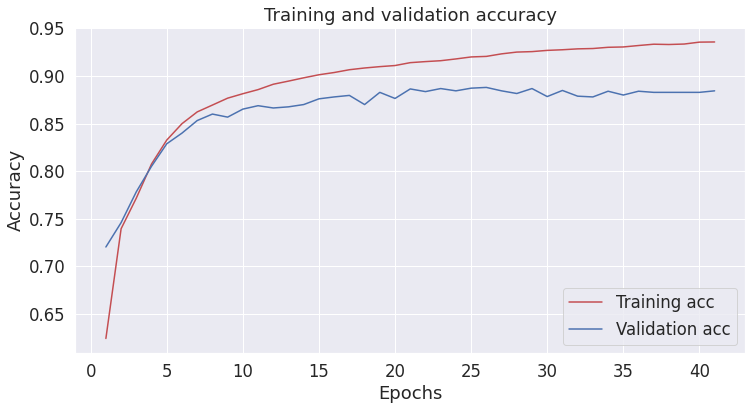

              precision    recall  f1-score   support

           0      0.889     0.886     0.887     12500
           1      0.886     0.890     0.888     12500

    accuracy                          0.888     25000
   macro avg      0.888     0.888     0.888     25000
weighted avg      0.888     0.888     0.888     25000


KFold: 6 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6904 - accuracy: 0.5630 - val_loss: 0.6748 - val_accuracy: 0.7156
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6652 - accuracy: 0.7009 - val_loss: 0.6280 - val_accuracy: 0.7568
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6115 - accuracy: 0.7714 - val_loss: 0.5717 - val_accuracy: 0.7884
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5550 - accuracy: 0.8048 - val_loss: 0.5195 - val_accuracy: 0.8176
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5

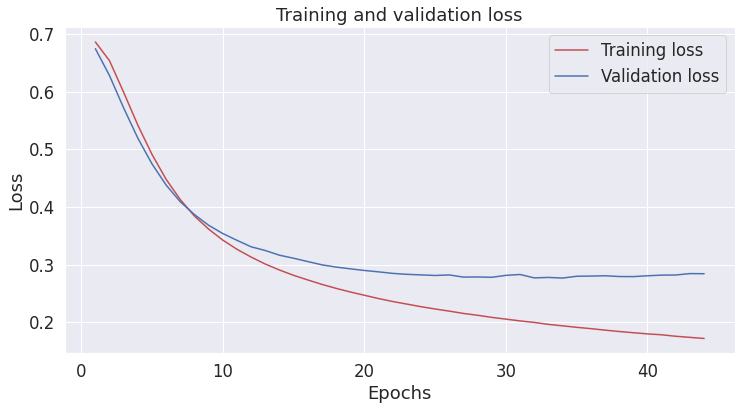

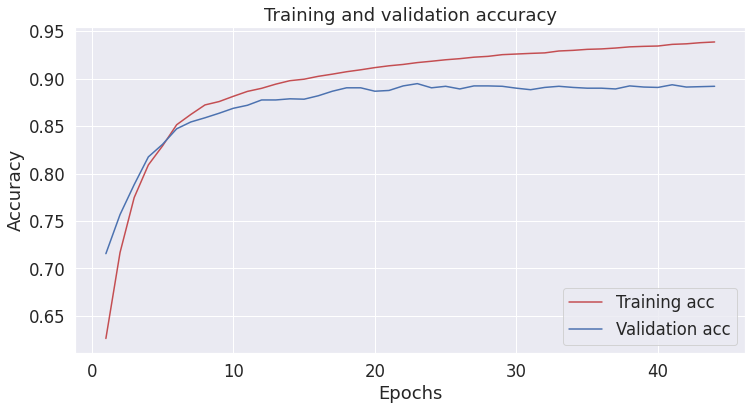

              precision    recall  f1-score   support

           0      0.885     0.890     0.887     12500
           1      0.889     0.884     0.887     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 7 starts.
Epoch 1/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6896 - accuracy: 0.5796 - val_loss: 0.6713 - val_accuracy: 0.6800
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6601 - accuracy: 0.7187 - val_loss: 0.6226 - val_accuracy: 0.7632
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6068 - accuracy: 0.7783 - val_loss: 0.5654 - val_accuracy: 0.8008
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5492 - accuracy: 0.8109 - val_loss: 0.5142 - val_accuracy: 0.8052
Epoch 5/100
176/176 [==============================] - 2s 10ms/step - loss: 0.4

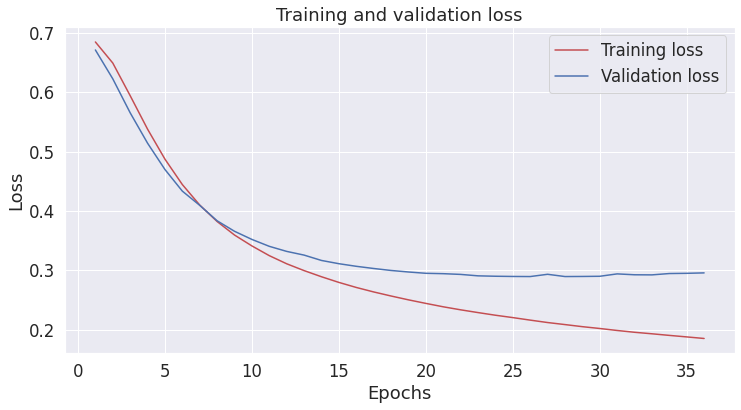

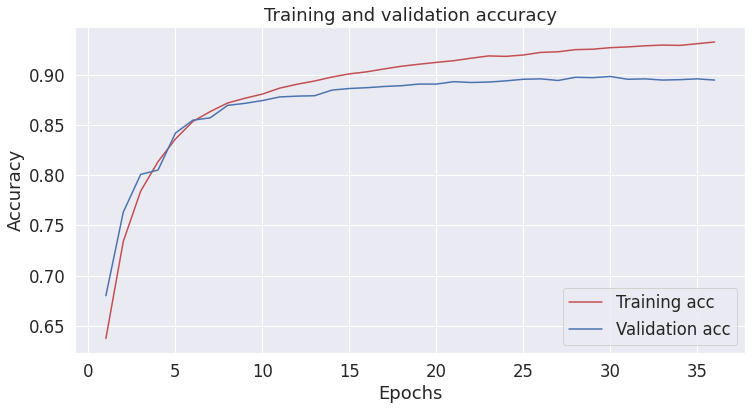

              precision    recall  f1-score   support

           0      0.892     0.879     0.885     12500
           1      0.880     0.894     0.887     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 8 starts.
Epoch 1/100
176/176 [==============================] - 3s 12ms/step - loss: 0.6899 - accuracy: 0.5484 - val_loss: 0.6747 - val_accuracy: 0.7256
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6644 - accuracy: 0.7165 - val_loss: 0.6303 - val_accuracy: 0.7764
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6150 - accuracy: 0.7720 - val_loss: 0.5759 - val_accuracy: 0.8000
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5578 - accuracy: 0.7956 - val_loss: 0.5249 - val_accuracy: 0.8288
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5

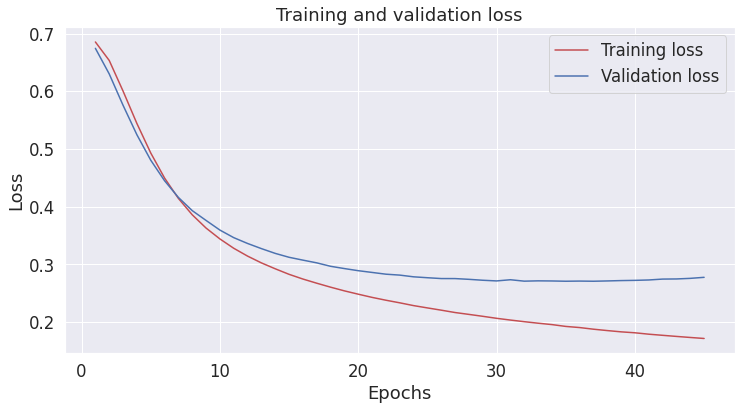

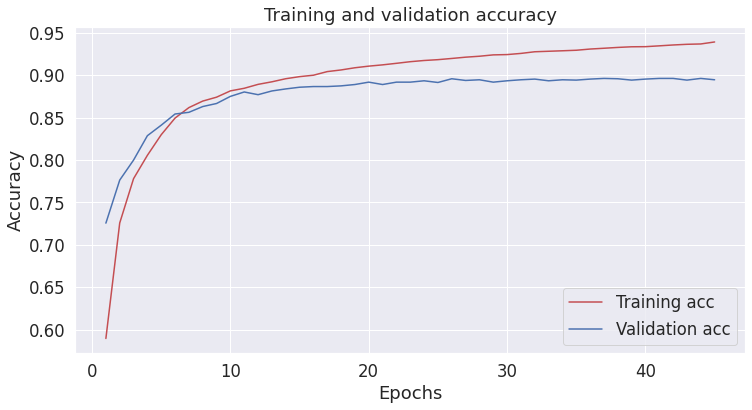

              precision    recall  f1-score   support

           0      0.881     0.892     0.886     12500
           1      0.891     0.880     0.885     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 9 starts.
Epoch 1/100
176/176 [==============================] - 3s 12ms/step - loss: 0.6899 - accuracy: 0.6108 - val_loss: 0.6742 - val_accuracy: 0.6324
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6614 - accuracy: 0.7137 - val_loss: 0.6283 - val_accuracy: 0.7480
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6098 - accuracy: 0.7717 - val_loss: 0.5760 - val_accuracy: 0.7692
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5522 - accuracy: 0.8004 - val_loss: 0.5254 - val_accuracy: 0.8072
Epoch 5/100
176/176 [==============================] - 2s 11ms/step - loss: 0.4

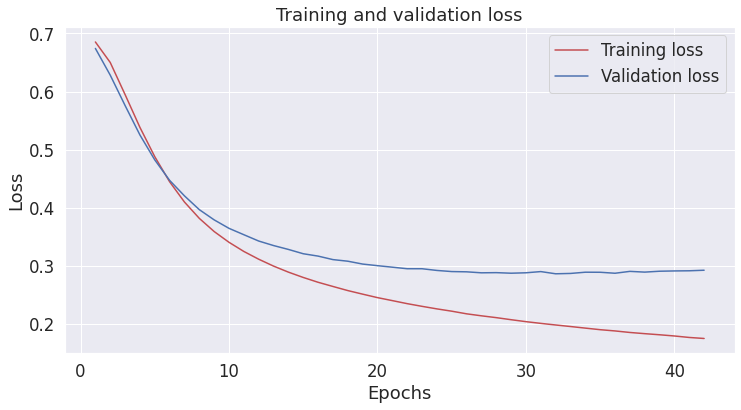

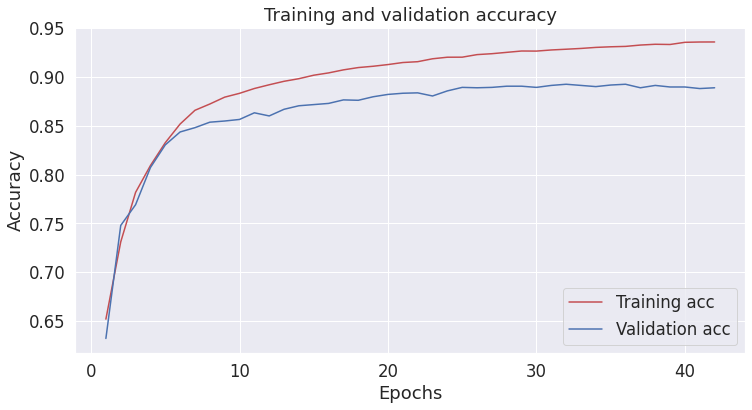

              precision    recall  f1-score   support

           0      0.890     0.879     0.884     12500
           1      0.880     0.891     0.886     12500

    accuracy                          0.885     25000
   macro avg      0.885     0.885     0.885     25000
weighted avg      0.885     0.885     0.885     25000


KFold: 10 starts.
Epoch 1/100
176/176 [==============================] - 3s 12ms/step - loss: 0.6905 - accuracy: 0.5622 - val_loss: 0.6753 - val_accuracy: 0.7112
Epoch 2/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6659 - accuracy: 0.6961 - val_loss: 0.6288 - val_accuracy: 0.7272
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.6152 - accuracy: 0.7533 - val_loss: 0.5703 - val_accuracy: 0.8004
Epoch 4/100
176/176 [==============================] - 2s 11ms/step - loss: 0.5576 - accuracy: 0.7974 - val_loss: 0.5168 - val_accuracy: 0.8244
Epoch 5/100
176/176 [==============================] - 2s 12ms/step - loss: 0.

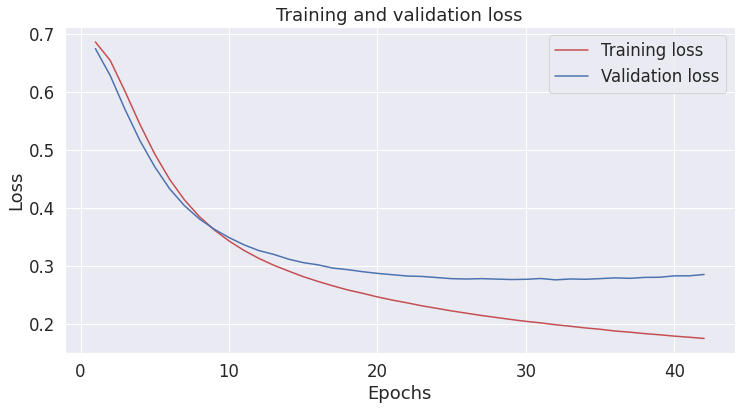

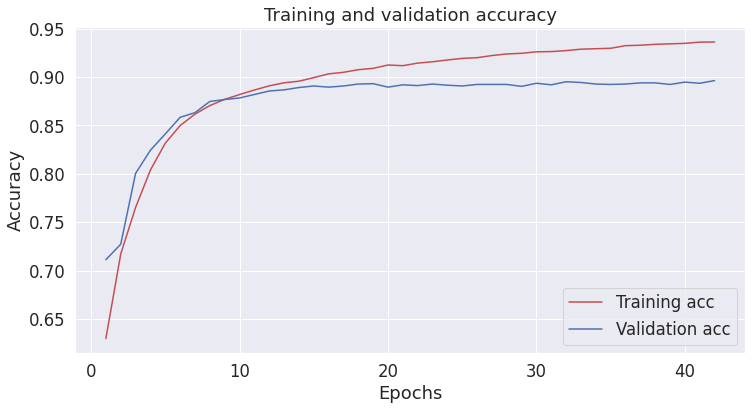

              precision    recall  f1-score   support

           0      0.882     0.893     0.887     12500
           1      0.891     0.881     0.886     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


Average accuracy: 0.8866 (+/- 0.0009)
Average loss: 0.2842 (+/- 0.0008)
Average F1: 0.8867 (+/- 0.0012)


In [6]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []

for n, (train, valid) in enumerate(kfold.split(x_train, y_train)):

  print("KFold: {} starts.".format(n + 1))
  del model
  tf.keras.backend.clear_session()
  
  model = Sequential([
    # We start off with an efficient embedding layer which maps our vocab indices into embedding_dims dimensions
    Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len),
    # We add a GlobalAveragePooling1D, which will average the embeddings of all words in the document
    GlobalAveragePooling1D(),
    # Output layer
    Dense(units=1, activation="sigmoid")
  ])

  model.compile(
      loss="binary_crossentropy",
      optimizer="adam",
      metrics=["accuracy"]
  )

  # model.summary()

  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=(x_train[valid], y_train[valid]),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback]
  )

  loss, acc = model.evaluate(x=x_test, y=y_test, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  # np.argmax(model.predict(x), axis=-1), if your model does multi-class classification (e.g. if it uses a softmax last-layer activation).
  # (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
  y_pred = (model.predict(x_test) > 0.5).astype("int32")
  report = classification_report(y_true=y_test, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_test, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
